In [1]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [9]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, pseudocount=False):
    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if pseudocount: 
            log2_fc = np.log2((np.expm1(avg1 * np.log(2)) + pseudocount) /(np.expm1(avg2 * np.log(2)) + pseudocount))
        else:
            log2_fc = avg1 - avg2
                
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    import matplotlib as mpl
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

In [46]:
def boxplots_from_log2FC(filtered, selected_genes=['gene'], 
                         title='all_cell_types', xlim=3, 
                         cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp', cbar_loc = [0.4, 0.02, 0.2, 0.02],
                         height=5, aspect = 0.5, vmin=-2, vmax = 2,
                        cts = ['Monocytes', 'cDCs', 'NK cells', 'T cells', 'B cells', 'Plasmablasts', 'pDCs'],
                        ):
    cond='Dengue_exposure'
    sample1 = 'Secondary'
    sample2 = 'Primary'
    n_sample = 0
    import matplotlib as mpl
    fig, axs = plt.subplots(1,len(cts),figsize=[1.7*len(cts), len(selected_genes)*0.2], sharey=True)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for i, ct in enumerate(cts):
        newdata = filtered[filtered.obs.cell_type_new == ct, selected_genes].copy()
        adata1 = newdata[newdata.obs[cond] == sample1].copy()
        adata2 = newdata[newdata.obs[cond] == sample2].copy()
        log2FCs = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=1e-3)
    
        palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
        sns.boxplot(data=log2FCs, orient="h", ax=axs[i], palette=palette)
        axs[i].set_title(ct)
        axs[i].set_xlim(xlim*-1, xlim)
        axs[i].tick_params(labelsize=12)
        for x in [-1, 0, 1]:
            axs[i].axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
        
        axs[i].set_ylabel(None)
        axs[i].set_xlabel(None)
        #axs[i].xaxis.set_label_position('bottom')
        
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    

    return fig, axs


In [ ]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'

adata = sc.read_h5ad(path + 'data/merged_citeseq_030905_8.h5ad')
filtered = adata[(adata.obs.Dataset.isin(['Children_viscRNAseq', 'Adults_citeseq'])) & 
                 (adata.obs.cell_quality == 'high')]

filtered=filtered[:, filtered.var.feature_types == 'Gene Expression']
sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered
sc.pp.filter_genes(filtered, min_cells=3)

filtered = filtered[(filtered.obs.ID.isin(['1-056-01', '1-172-01', '1_003_1', '1_053_01', '1_183_01',
                                          '1_001_1', '1_013_01', '1_026_02', '1_036_02', '5_049_01',
                                           '1_019_01', '6_023_01', '5_030_01', '5_193_01', '5_154_01', 
                                            '6_001_01', '5_041_01', '1_140_01', '1_144_01', '5_044_01', 
                                            '1_002_01', '1_113_01', '5_010_01', '5_130_01'
                                          ]))].copy()

filtered = filtered[filtered.obs.Condition == 'SD']
sc.pp.filter_genes(filtered, min_cells=3)
filtered.obs.Dengue_exposure.cat.categories

In [ ]:
genes_up = [# Receptors for Endocytosis / Phagocytosis
#    "FCGR1A", "FCGR2A", "FCGR2B", "CLEC5A", "CD209", "MRC1", "SIGLEC1",
#    "CD36", 'LILRB1',    
    # Actin Cytoskeleton Regulators
#    "RAC1", "CDC42", "RHOA", "ARPC2", "WASF2",
    # Adaptor & Signaling Proteins
#    "SYK", "LYN", "HCK", "TYROBP", "TLR2", "TLR4",
    # Other / General Vesicular Transport
#    "CLTC", "CAV1", "EEA1", #"RAB5A",
#    'IFNG', 'IL10', 
    "TAP1", "TAP2", "TAPBP", "PSMB8", "PSMB9", "PSMB10", 
            "PSME1", "PSME2", "B2M",'CALR', "PDIA3", 
    "ERAP1", "ERAP2", 'RBX1', 'UBE2L3', 'IRF1', "LAP3",
    'NPEPPS', "LNPEP", "HLA-E", "HLA-F", "HLA-G",
            "HLA-A", "HLA-B", "HLA-C", 
            "HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB", "CD74", 'CIITA',
    'CTSS', 'CTSB', 'CTSL', 'CAPN1', "LAMP1", "LAMP2", 'SEC61A1',
    'RAB5A', 'RAB7A', 'PHF11', "IFI30", "LGMN",
    "ANPEP", "TFEB", "CST3", 
            "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "HLA-DQB1", "HLA-DRA", "HLA-DRB1", "HLA-DRB5", 
           ]



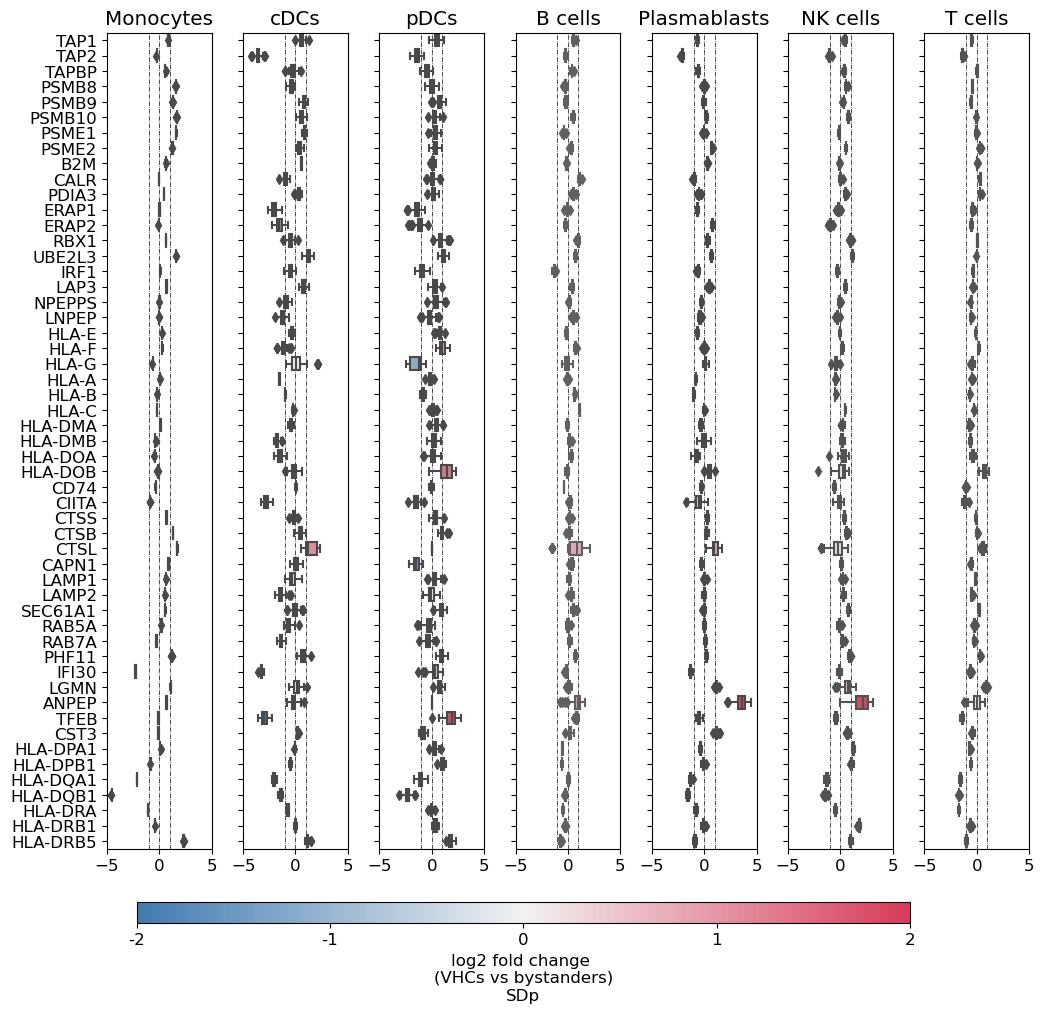

In [47]:
cts = ['Monocytes', 'cDCs', 'pDCs', 'B cells', 'Plasmablasts', 'NK cells', 'T cells',  ]
fig, ax = boxplots_from_log2FC(filtered, selected_genes=genes_up, xlim=5, 
                         cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp', 
                               cbar_loc = [0.4, 0.02, 0.2, 0.02],
                         height=10, aspect = 2, vmin=-2, vmax = 2,
                        cts = cts,
                        )
plt.show()

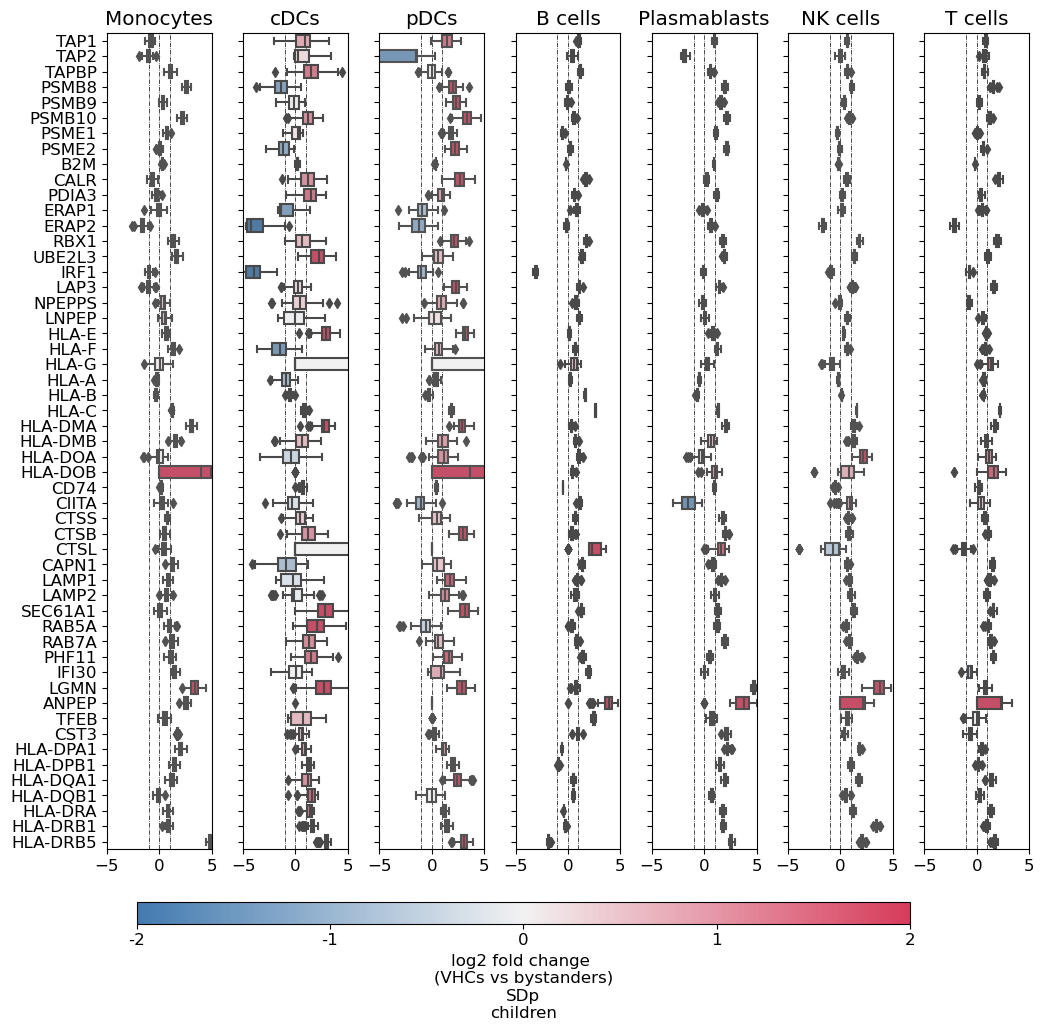

In [49]:
cts = ['Monocytes', 'cDCs', 'pDCs', 'B cells', 'Plasmablasts', 'NK cells', 'T cells',  ]
fig, ax = boxplots_from_log2FC(filtered[filtered.obs.Dataset.isin(['Children_viscRNAseq'])], selected_genes=genes_up, xlim=5, 
                         cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp\nchildren', 
                               cbar_loc = [0.4, 0.02, 0.02, 0.02],
                         height=10, aspect = 2, vmin=-2, vmax = 2,
                        cts = cts,
                        )
plt.show()

In [18]:
genes_up = [# Receptors for Endocytosis / Phagocytosis
#    "FCGR1A", "FCGR2A", "FCGR2B", "CLEC5A", "CD209", "MRC1", "SIGLEC1",
#    "CD36", 'LILRB1',    
    # Actin Cytoskeleton Regulators
#    "RAC1", "CDC42", "RHOA", "ARPC2", "WASF2",
    # Adaptor & Signaling Proteins
#    "SYK", "LYN", "HCK", "TYROBP", "TLR2", "TLR4",
    # Other / General Vesicular Transport
#    "CLTC", "CAV1", "EEA1", #"RAB5A",
#    'IFNG', 'IL10', 
    "TAP1", "TAP2", "TAPBP", "PSMB8", "PSMB9", "PSMB10", 
            "PSME1", "PSME2", "B2M",'CALR', "PDIA3", 
    "ERAP1", "ERAP2", 'RBX1', 'UBE2L3', 'IRF1', "LAP3",
    'NPEPPS', "LNPEP", "HLA-E", "HLA-F", "HLA-G",
            "HLA-A", "HLA-B", "HLA-C", 
            "HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB", "CD74", 'CIITA',
    'CTSS', 'CTSB', 'CTSL', 'CAPN1', "LAMP1", "LAMP2", 'SEC61A1',
    'RAB5A', 'RAB7A', 'PHF11', "IFI30", "LGMN",
    "ANPEP", "TFEB", "CST3", 
            "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "HLA-DQB1", "HLA-DRA", "HLA-DRB1", "HLA-DRB5", 
           ]



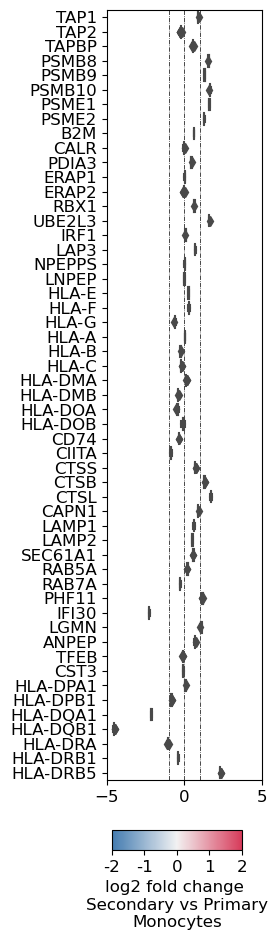

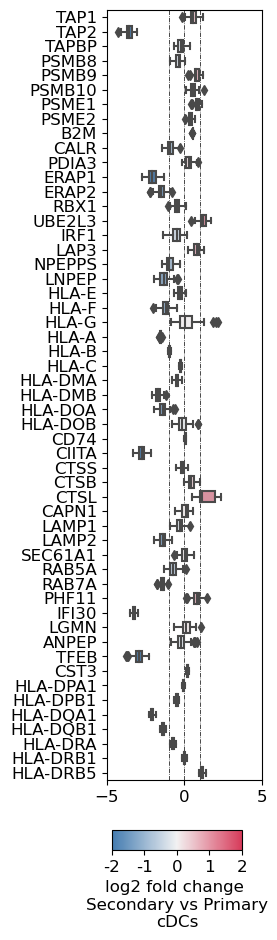

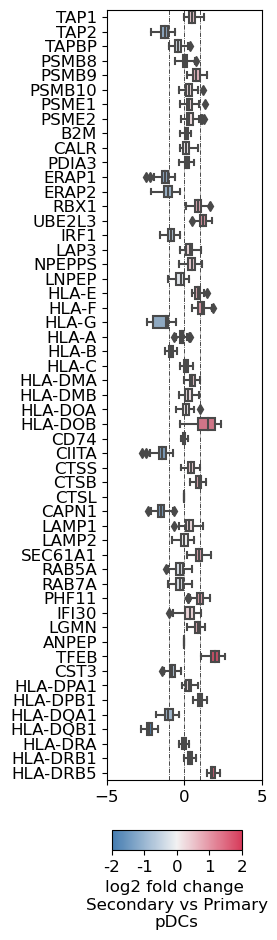

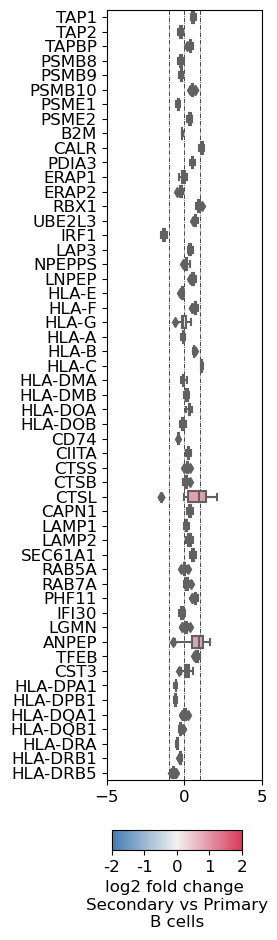

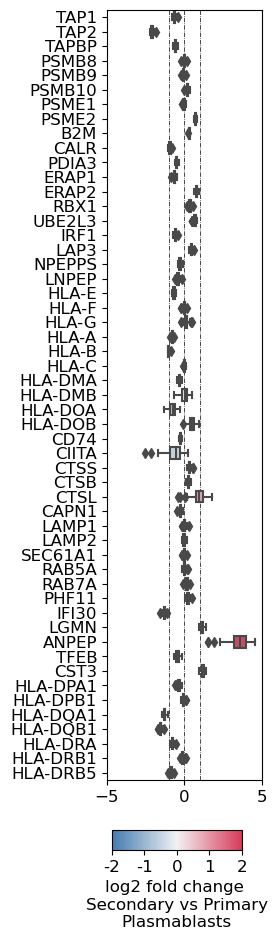

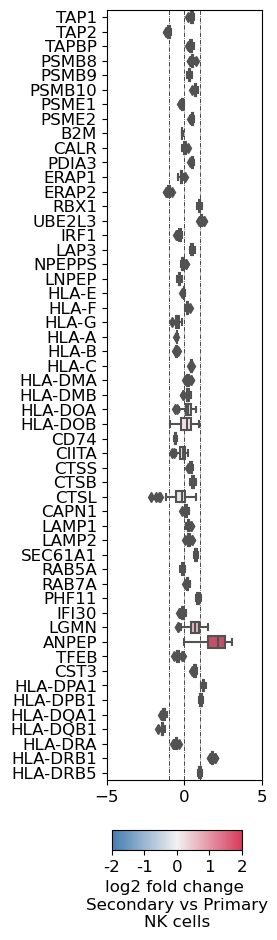

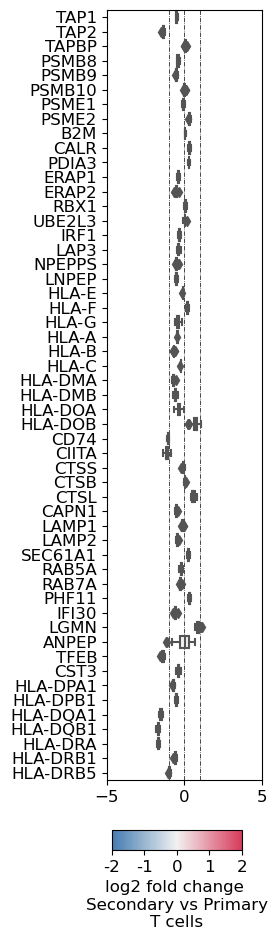

In [32]:
cts = ['Monocytes', 'cDCs', 'pDCs', 'B cells', 'Plasmablasts', 'NK cells', 'T cells',  ]

cond='Dengue_exposure'
sample1 = 'Secondary'
sample2 = 'Primary'
n_sample = 0

log2fcs = {}
for ct in cts:
    newdata = filtered[filtered.obs.cell_type_new == ct, genes_up].copy()
    adata1 = newdata[newdata.obs[cond] == sample1].copy()
    adata2 = newdata[newdata.obs[cond] == sample2].copy()
    log2fc1 = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=1e-3)
    log2fcs[ct] = log2fc1
    fig, ax = boxplot_from_log2FC(log2fc1, 
                              xlim=5, vmin=-2, vmax=2,
                              title='',
                              height=10, aspect = 0.2, 
                              cbar_label= f'log2 fold change \n{sample1} vs {sample2}\n{ct}',
                             )
    plt.show()


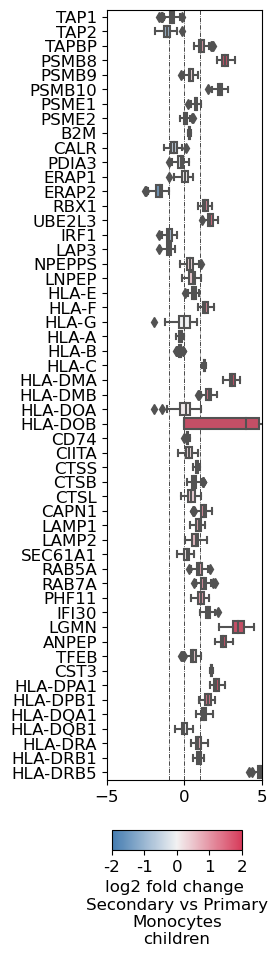

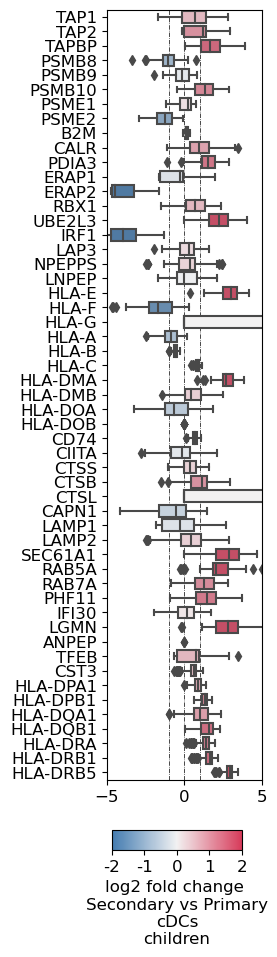

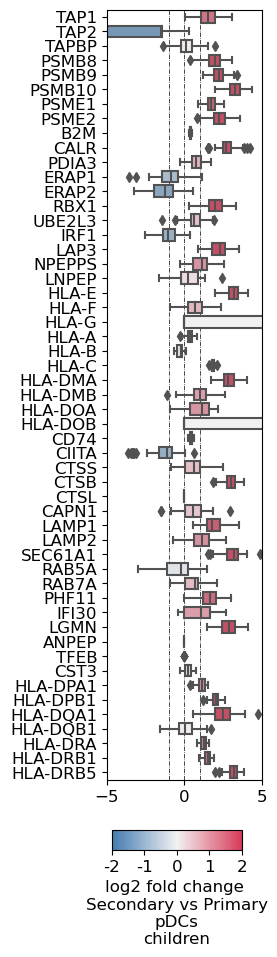

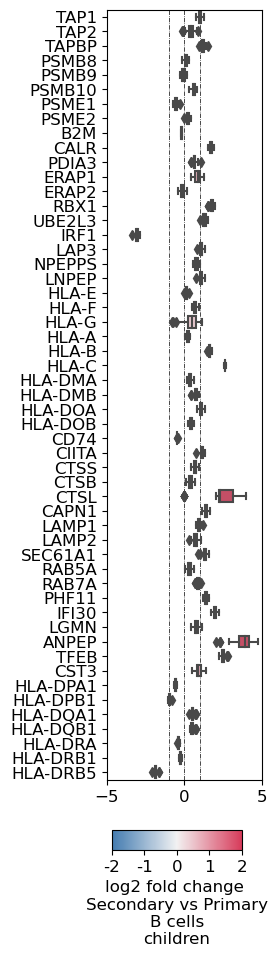

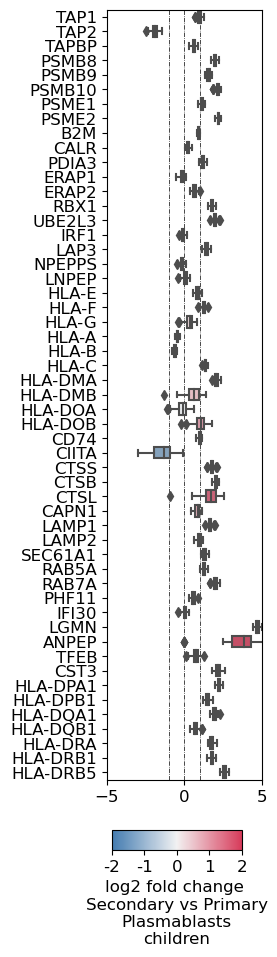

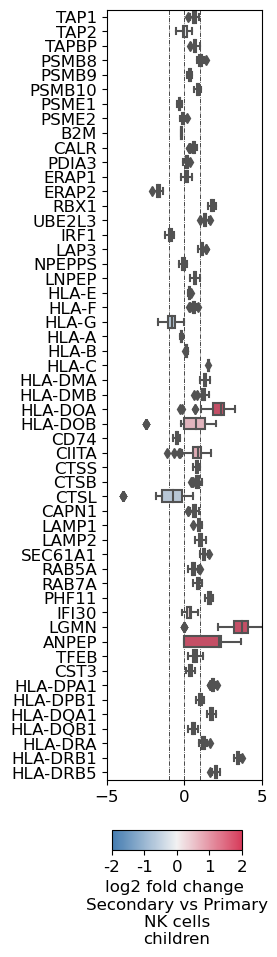

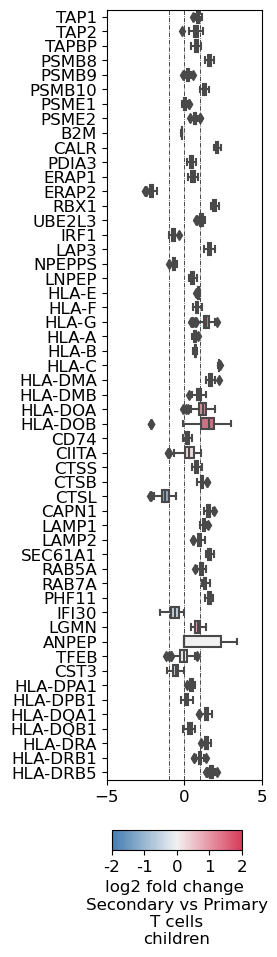

In [33]:
cts = ['Monocytes', 'cDCs', 'pDCs', 'B cells', 'Plasmablasts', 'NK cells', 'T cells',  ]

cond='Dengue_exposure'
sample1 = 'Secondary'
sample2 = 'Primary'
n_sample = 0

log2fcs_p = {}
for ct in cts:
    newdata = filtered[((filtered.obs.cell_type_new == ct) & (filtered.obs.Dataset.isin(['Children_viscRNAseq']))), genes_up].copy()
    adata1 = newdata[newdata.obs[cond] == sample1].copy()
    adata2 = newdata[newdata.obs[cond] == sample2].copy()
    log2fc1 = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=1e-3)
    log2fcs_p[ct] = log2fc1
    fig, ax = boxplot_from_log2FC(log2fc1, 
                              xlim=5, vmin=-2, vmax=2,
                              title='',
                              height=10, aspect = 0.2, 
                              cbar_label= f'log2 fold change \n{sample1} vs {sample2}\n{ct}\nchildren',
                             )
    plt.show()


In [40]:
filtered.obs.groupby(['cell_type_new', 'Dataset', 'Condition', 'ID']).size()

cell_type_new  Dataset              Condition  ID      
B cells        Adults_citeseq       SD         1_001_1      954
                                               1_002_01       0
                                               1_013_01     693
                                               1_026_02    1321
                                               1_036_02     912
                                                           ... 
Platelets      Children_viscRNAseq  SD         5_030_01       2
                                               5_041_01       4
                                               5_044_01       0
                                               5_049_01       0
                                               5_193_01       4
Length: 312, dtype: int64

In [50]:
def med_pair(filtered, obs='Condition', obs_keys = ['S_dengue', 'dengue'], 
                         ct_obs = 'rna_ct_2_2', ct='NK cells', 
                         ncells=5, pseudocount=False):
    adata_ct = filtered[filtered.obs[ct_obs] == ct].copy()
    IDs=[]
    for ID in adata_ct.obs.ID.unique():
        if adata_ct[adata_ct.obs.ID == ID].obs.shape[0] >= ncells: IDs.append(ID)
    adata_ct = adata_ct[adata_ct.obs['ID'].isin(IDs)]
        
    adata_S_ct = adata_ct[adata_ct.obs[obs].isin([obs_keys[0]])]
    adata_D_ct = adata_ct[adata_ct.obs[obs].isin([obs_keys[1]])]
    
    df_S = sc.get.obs_df(adata_S_ct, keys=[*adata_ct.var_names, 'ID']).groupby(['ID']).mean().dropna().T
    df_D = sc.get.obs_df(adata_D_ct, keys=[*adata_ct.var_names, 'ID']).groupby(['ID']).mean().dropna().T
    
    df_new = pd.DataFrame()
    for col in df_S.columns:
        if pseudocount: 
            avg1=df_D.T
            avg2=df_S[col].T
            df1 = np.log2((np.expm1(avg1 * np.log(2)) + pseudocount) /(np.expm1(avg2 * np.log(2)) + pseudocount))
        else:
            df1 = df_D.T - df_S[col].T
        df1.index = [col+'__'+x for x in df1.index]
        df_new = pd.concat([df_new, df1], axis=0)
    df_new = df_new * -1
    df_new = df_new
    if ct == 'conventional DCs': df_new['cell_type'] = 'cDCs'
    else: df_new['cell_type'] = ct
    
    df_new['SD'] = [x.split('__')[0] for x in df_new.index]
    df_new['D'] = [x.split('__')[1] for x in df_new.index]
    df_new = df_new.reset_index().set_index(['cell_type', 'SD', 'D'])
    del(df_new['index'])
    return(df_new)


In [51]:
def boxplots_from_log2FC(df, selected_genes=['gene'], 
                         title='all_cell_types', xlim=3, 
                         cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp', cbar_loc = [0.4, 0.02, 0.2, 0.02],
                         height=5, aspect = 0.5, vmin=-2, vmax = 2,
                        cts = ['Monocytes', 'cDCs', 'NK cells', 'T cells', 'B cells', 'Plasmablasts', 'pDCs'],
                        ):
    import matplotlib as mpl
    fig, axs = plt.subplots(1,len(cts),figsize=[1.7*len(cts), len(selected_genes)*0.2], sharey=True)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for i, ct in enumerate(cts):
        log2FCs = df.loc[ct]
    
        palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
        sns.boxplot(data=log2FCs, orient="h", ax=axs[i], palette=palette)
        axs[i].set_title(ct)
        axs[i].set_xlim(xlim*-1, xlim)
        axs[i].tick_params(labelsize=12)
        for x in [-1, 0, 1]:
            axs[i].axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
        
        axs[i].set_ylabel(None)
        axs[i].set_xlabel(None)
        #axs[i].xaxis.set_label_position('bottom')
        
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    

    return fig, axs

def heatmaps_from_log2FC(all_stats2, selected_genes=['gene'], cols = ['adults', 'children'],
                         cts = ['Monocytes', 'cDCs', 'NK cells', 'T cells', 'B cells', 'Plasmablasts', 'pDCs'],
                         cbar_label = f'log2 fold change\nSDp vs D', cbar_loc = [0.4, 0.02, 0.2, 0.02],
                         vmin=-2, vmax = 2, short_label=False, cmap = sns.diverging_palette(245, 5, as_cmap=True)):
    fig, axs = plt.subplots(1,len(cts),figsize=[1.7*len(cts), len(selected_genes)*0.2])
    #cmap = 'bwr' # sns.diverging_palette(245, 5, as_cmap=True) #"coolwarm", "vlag"
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for i, ct in enumerate(cts):
        df_ct = all_stats2.loc[ct]
        df_ct = df_ct.loc[selected_genes]
        sns.heatmap(df_ct[cols], cmap=cmap, center=0, 
                yticklabels= i==0, vmin=vmin, vmax=vmax, ax = axs[i],
                     cbar= False #i==2, cbar_kws={'label': f'log2 fold change\nSDp vs D', 'shrink': .3}
               )
        axs[i].set_ylabel(None)
        axs[i].set_xticklabels(cols)
        axs[i].xaxis.tick_top() # x axis on top
        if short_label: axs[i].set_xlabel('\n'.join(ct.split()))
        else: axs[i].set_xlabel(ct)
        axs[i].xaxis.set_label_position('bottom')

    ax_cb = fig.add_axes(cbar_loc)
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    return fig, axs



In [52]:
df_all = pd.DataFrame([])
for ct in cts:
    df = med_pair(filtered[:,genes_up], obs='Dengue_exposure', obs_keys = ['Secondary', 'Primary'], 
                  ct_obs = 'cell_type_new', ct=ct, ncells=5, pseudocount=1e-3)
    df = df.reset_index().set_index(['cell_type', 'SD', 'D'])
    df_all = pd.concat([df_all, df], axis=0)
df_all

TAP1      TAP2     TAPBP     PSMB8     PSMB9  \
cell_type SD       D                                                            
Monocytes 1_001_1  1_036_02 -1.392236  0.246957  0.654121 -1.711216 -2.850442   
                   1_140_01 -1.888308  2.444991  3.616169 -0.947629 -5.409956   
                   5_041_01 -3.652620 -0.235850  1.322778 -1.531255 -4.971532   
                   5_049_01 -1.296401  0.283414  0.913823 -3.094011 -4.227677   
          1_002_01 1_036_02 -0.637966 -3.487197 -2.361063  0.543123  1.787438   
...                               ...       ...       ...       ...       ...   
T cells   5_044_01 5_049_01 -0.170585 -5.658650 -0.076177 -0.656796  1.443051   
          5_193_01 1_036_02  1.212997 -3.938656  0.650026  1.266517  0.774829   
                   1_140_01  1.151176  1.315036  0.826754  2.397759 -0.363535   
                   5_041_01  1.869778  1.289991  2.225051  2.321545  0.011196   
                   5_049_01 -0.027707 -4.119565  1.119923 -0.070724 -0.214659   

                               PSMB10     PSME1     PSME2       B2M      CALR  \
cell_type SD       D                                                            
Monocytes 1_001_1  1_036_02 -1.995157 -2.954558 -2.800491 -1.115698 -0.156489   
                   1_140_01 -2.555424 -5.652621 -7.100234 -2.413050  0.864237   
                   5_041_01 -2.079204 -5.129798 -4.569271 -1.868266 -0.709283   
                   5_049_01 -2.895285 -3.507912 -2.328697 -1.199463 -0.243444   
          1_002_01 1_036_02  1.690080  1.564625  1.066685  1.486968 -2.582021   
...                               ...       ...       ...       ...       ...   
T cells   5_044_01 5_049_01  0.405425  1.992289  1.635162  1.315301 -0.457734   
          5_193_01 1_036_02  1.112459  1.768820  1.664202  0.202009  0.931608   
                   1_140_01  0.822501 -0.661260 -0.303582 -0.788578  3.724214   
                   5_041_01  1.378918  0.875726  1.482844 -0.555809  3.935665   
                   5_049_01 -0.401962  1.780617  1.195689  0.301424  1.461129   

                             ...     ANPEP      TFEB      CST3  HLA-DPA1  \
cell_type SD       D         ...                                           
Monocytes 1_001_1  1_036_02  ...  2.065681 -0.154442 -4.465417 -5.141486   
                   1_140_01  ...  4.339754  1.345470 -4.685029 -5.385270   
                   5_041_01  ...  4.228319  0.876374 -3.381638 -4.036828   
                   5_049_01  ...  0.108373 -0.564702 -4.745080 -4.984252   
          1_002_01 1_036_02  ... -0.191255 -1.506422  1.253802 -1.483238   
...                          ...       ...       ...       ...       ...   
T cells   5_044_01 5_049_01  ... -2.368353 -4.544562 -1.077878  1.169433   
          5_193_01 1_036_02  ... -1.865838 -2.717910 -0.520786 -1.078283   
                   1_140_01  ... -0.000000 -0.298658 -0.753486 -1.810041   
                   5_041_01  ... -0.000000  1.302659 -0.025598 -0.273422   
                   5_049_01  ... -2.368353 -3.734104 -0.740236 -2.055378   

                             HLA-DPB1  HLA-DQA1   HLA-DQB1   HLA-DRA  \
cell_type SD       D                                                   
Monocytes 1_001_1  1_036_02 -5.485919 -3.609089  -6.026534 -5.340206   
                   1_140_01 -4.858168  2.568545  -2.153670 -2.757750   
                   5_041_01 -3.657082 -0.542705  -0.018590 -3.845031   
                   5_049_01 -4.793766 -3.539137  -0.628712 -4.153669   
          1_002_01 1_036_02 -3.580890 -7.272110 -10.152066 -4.445949   
...                               ...       ...        ...       ...   
T cells   5_044_01 5_049_01  0.632536 -0.553241  -0.203741 -2.559682   
          5_193_01 1_036_02 -1.068607 -3.348438  -3.476007 -2.406980   
                   1_140_01 -1.130122 -0.981403  -1.485175 -0.785019   
                   5_041_01 -0.921696  0.737314   1.460729  0.948184   
                   5_049_01 -2.019933 -3.302054  -1.180434 -3.163894   


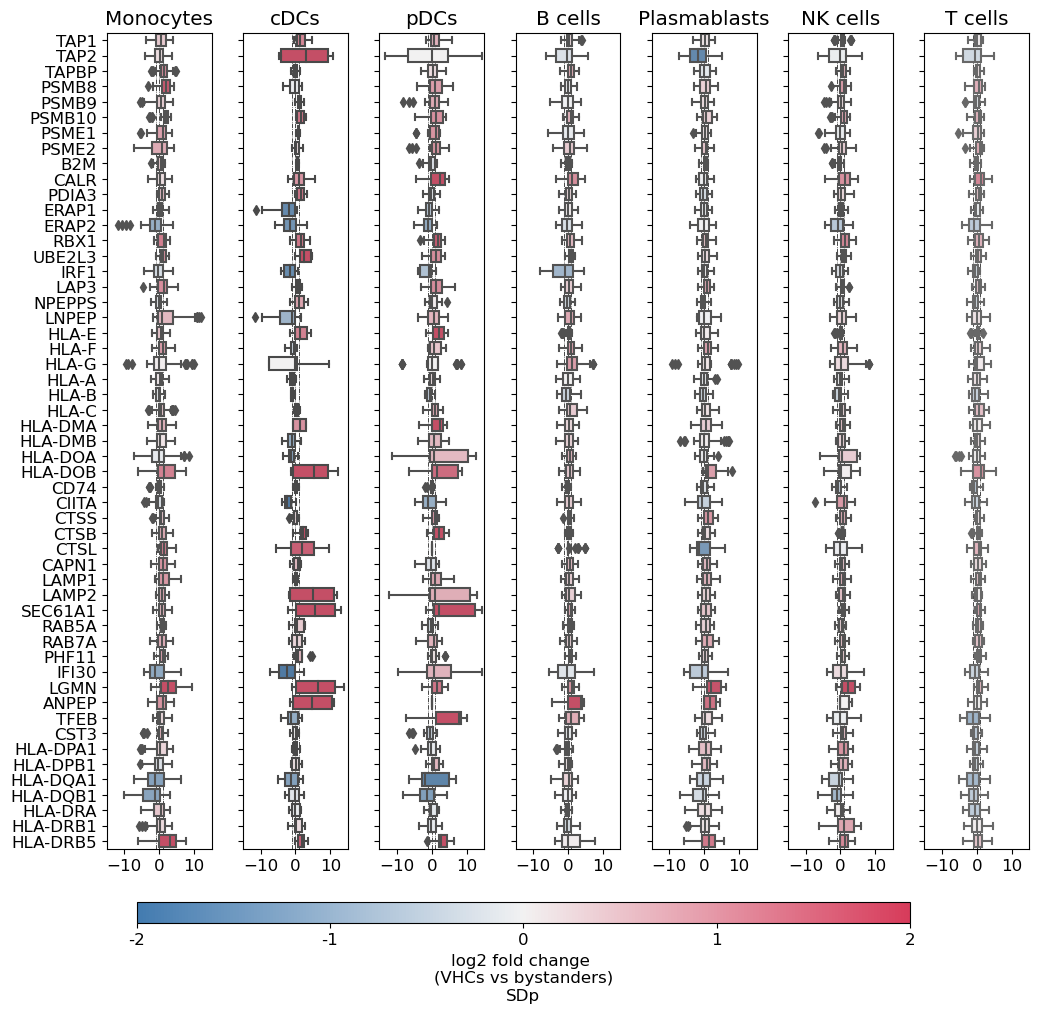

In [54]:
fig, ax = boxplots_from_log2FC(df_all[genes_up], selected_genes=genes_up, xlim=15,
                               cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp', 
                               cbar_loc = [0.4, 0.02, 0.2, 0.02],
                              height=10, aspect = 2, vmin=-2, vmax = 2,
                               cts=cts
                             )
plt.show()



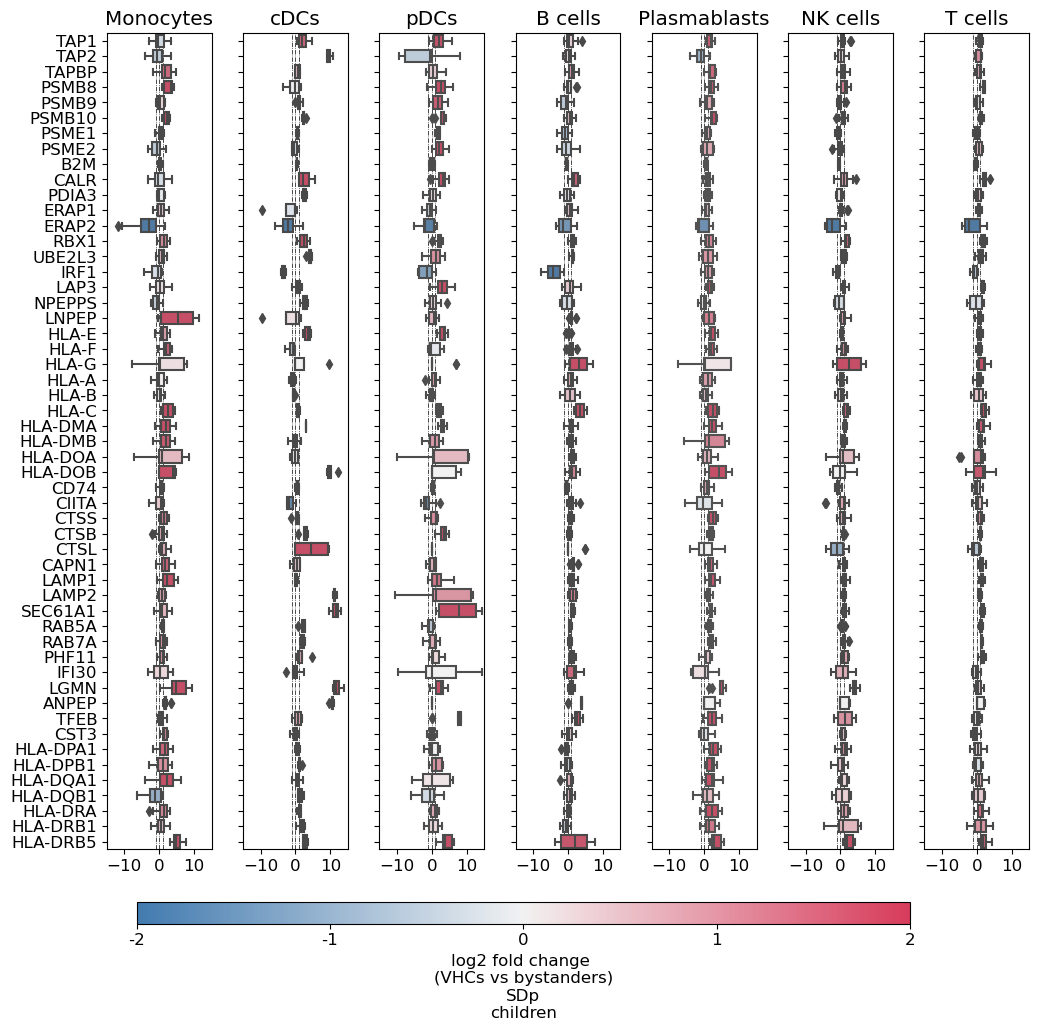

In [55]:
df_all = pd.DataFrame([])
for ct in cts:
    df = med_pair(filtered[filtered.obs.Dataset.isin(['Children_viscRNAseq']),genes_up], obs='Dengue_exposure', obs_keys = ['Secondary', 'Primary'], 
                  ct_obs = 'cell_type_new', ct=ct, ncells=5, pseudocount=1e-3)
    df = df.reset_index().set_index(['cell_type', 'SD', 'D'])
    df_all = pd.concat([df_all, df], axis=0)
df_all

fig, ax = boxplots_from_log2FC(df_all[genes_up], selected_genes=genes_up, xlim=15,
                               cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp\nchildren', 
                         cbar_loc = [0.4, 0.02, 0.2, 0.02],
                              height=10, aspect = 2, vmin=-2, vmax = 2,
                               cts=cts
                             )
plt.show()


In [56]:
filtered.obs.Dataset.unique()

['Children_viscRNAseq', 'Adults_citeseq']
Categories (2, object): ['Adults_citeseq', 'Children_viscRNAseq']

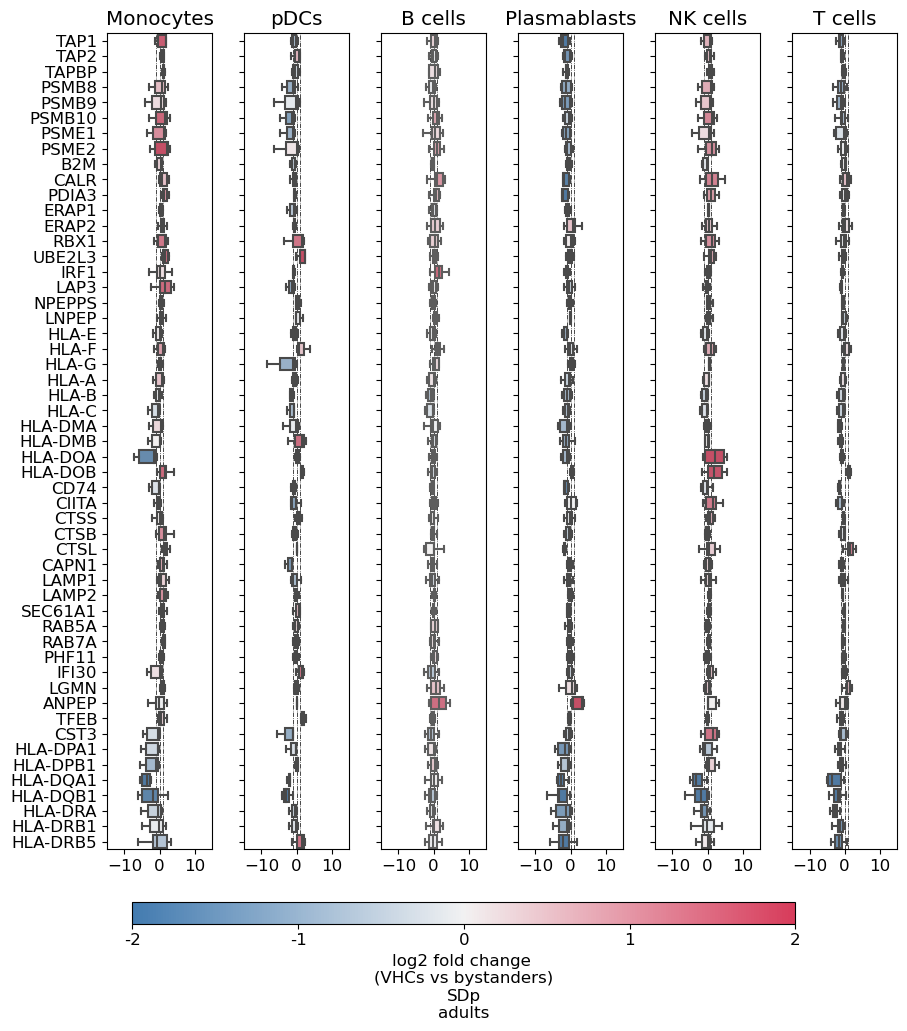

In [59]:
df_all = pd.DataFrame([])
for ct in cts:
    df = med_pair(filtered[filtered.obs.Dataset.isin(['Adults_citeseq']),genes_up], obs='Dengue_exposure', obs_keys = ['Secondary', 'Primary'], 
                  ct_obs = 'cell_type_new', ct=ct, ncells=5, pseudocount=1e-3)
    df = df.reset_index().set_index(['cell_type', 'SD', 'D'])
    df_all = pd.concat([df_all, df], axis=0)
df_all

fig, ax = boxplots_from_log2FC(df_all[genes_up], selected_genes=genes_up, xlim=15,
                               cbar_label= 'log2 fold change \n(VHCs vs bystanders)\nSDp\nadults', 
                         cbar_loc = [0.4, 0.02, 0.2, 0.02],
                              height=10, aspect = 2, vmin=-2, vmax = 2,
                               cts=[x for x in cts if x not in ['cDCs']]
                             )
plt.show()
